In [1]:
# Import all the dependencies
import nilearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from tqdm.notebook import tqdm_notebook as tqdm
import cv2
import skimage
from skimage.transform import resize
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Import the dataset. 
df_loc = r"resized_df_256_256.pkl"
resized_df = pd.read_pickle(df_loc)
resized_df.sample(5)

,PID,Images,Tumor Mask,Tumor Border,Labels,File name
2120,MR050791B,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[280.9756097560976, 277.4076655052265, 289.895...",Glioma,2907.mat
577,103671,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[233.70034843205576, 290.78745644599303, 229.2...",Pituitary,1518.mat
349,103478,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[242.62020905923345, 174.82926829268294, 234.5...",Pituitary,1312.mat
318,101145,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[253.32404181184668, 209.61672473867597, 241.7...",Pituitary,1285.mat
22,114361,"[[1.5259021896696422e-05, 1.5259021896696422e-...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[225.11533591612212, 238.17663526961726, 235.8...",Pituitary,1018.mat


In [4]:
# ## This code block displays a random MR Image & Tumor Mask

# randInt = np.random.randint(0,len(resized_df))

# # create figure
# fig = plt.figure(figsize=(10, 7))
  
# # setting values to rows and column variables
# rows = 1
# columns = 2

# img  = resized_df.Images[randInt]
# mask = resized_df["Tumor Mask"][randInt]
# tumorBorder = resized_df["Tumor Border"][randInt]


# # Display Original Image
# fig.add_subplot(rows, columns, 1)
# plt.imshow(img, cmap='gray')
# plt.title('Original Image ({})'.format(resized_df.Labels[randInt]))
# plt.axis('off')
  
# # Display Tumor Mask
# fig.add_subplot(rows, columns, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Tumor Mask ({})'.format(resized_df.Labels[randInt]))
# plt.axis('off')
# plt.show()

In [5]:
# # 1. Resize images and masks
# ## Image Resizing from (512, 512) pixals to (128, 128)
img_shape  = 256
mask_shape = 256

# def imgResize(img):
#     return resize(img,(img_shape, img_shape))

# resized_df['Images'] = resized_df['Images'].apply(imgResize)
# resized_df['Tumor Mask'] = resized_df['Tumor Mask'].apply(imgResize)

In [6]:
# ## This code block displays a random MR Image & Tumor Mask

# randInt = np.random.randint(0,len(df))

# # create figure
# fig = plt.figure(figsize=(24, 12))
  
# # setting values to rows and column variables
# rows = 1
# columns = 4

# ori_img  = df.Images[randInt]
# ori_mask = df["Tumor Mask"][randInt]
# resized_img  = resized_df.Images[randInt]
# resized_mask = resized_df["Tumor Mask"][randInt]

# # Display Original Image
# fig.add_subplot(rows, columns, 1)
# plt.imshow(ori_img, cmap='gray')
# plt.title('Original Image ({})'.format(df.Labels[randInt]))
# plt.axis('off')
  
# # Display Tumor Mask
# fig.add_subplot(rows, columns, 2)
# plt.imshow(resized_img, cmap='gray')
# plt.title('Resized Image ({})'.format(df.Labels[randInt]))
# plt.axis('off')

# # Display Original Image
# fig.add_subplot(rows, columns, 3)
# plt.imshow(ori_mask, cmap='gray')
# plt.title('Original Tumor mask ({})'.format(df.Labels[randInt]))
# plt.axis('off')
  
# # Display Tumor Mask
# fig.add_subplot(rows, columns, 4)
# plt.imshow(resized_mask, cmap='gray')
# plt.title('Resized Tumor Mask ({})'.format(df.Labels[randInt]))
# plt.axis('off')

# plt.show()
# del df

In [7]:
## Splitting Images form masks
Y = resized_df["Tumor Mask"].tolist()
X = resized_df['Images'].tolist()

## Adding extra Color channel to the grayscale images
Y = np.array(Y).reshape(-1, mask_shape, mask_shape, 1)
Y = Y.astype(float)

X = np.array(X).reshape(-1, img_shape, img_shape, 1)
X = X*255

print(f"shape of Images: {X.shape}, shape of the labels {Y.shape}")

shape of Images: (3064, 256, 256, 1), shape of the labels (3064, 256, 256, 1)


In [9]:
# copy = X[0]*255

In [10]:
# copy.min()

In [11]:
# plt.imshow(X[0].reshape(img_shape, img_shape), cmap='gray')
# plt.show()

In [8]:
## Splitting Data to : 75% Train set, 15% Test set, and 10% Validation set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_test,Y_test, test_size=0.40, random_state=42)

In [9]:
print("X_train shape:", X_train.shape,"| Y_train shape:", Y_train.shape)
print("X_test shape : ",X_test.shape,"| Y_test shape : ", Y_test.shape)
print("X_val shape  : ",X_val.shape,"| Y_val shape  : ", Y_val.shape)
print("\nTotal Data: ", len(resized_df))

X_train shape: (2298, 256, 256, 1) | Y_train shape: (2298, 256, 256, 1)
X_test shape :  (459, 256, 256, 1) | Y_test shape :  (459, 256, 256, 1)
X_val shape  :  (307, 256, 256, 1) | Y_val shape  :  (307, 256, 256, 1)

Total Data:  3064


In [10]:
# # Building Unet by dividing encoder and decoder into blocks

# def conv_block(input, num_filters):
#     x = Conv2D(num_filters, 3, padding="same")(input)
#     x = BatchNormalization()(x)   #Not in the original network. 
#     x = Activation("relu")(x)

#     x = Conv2D(num_filters, 3, padding="same")(x)
#     x = BatchNormalization()(x)  #Not in the original network
#     x = Activation("relu")(x)

#     return x

# #Encoder block: Conv block followed by maxpooling


# def encoder_block(input, num_filters):
#     x = conv_block(input, num_filters)
#     p = MaxPool2D((2, 2))(x)
#     return x, p   

# #Decoder block
# #skip features gets input from encoder for concatenation

# def decoder_block(input, skip_features, num_filters):
#     x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
#     x = Concatenate()([x, skip_features])
#     x = conv_block(x, num_filters)
#     return x

# #Build Unet using the blocks
# def build_unet(input_shape):
#     inputs = Input(input_shape)

#     s1, p1 = encoder_block(inputs, 64)
#     s2, p2 = encoder_block(p1, 128)
#     s3, p3 = encoder_block(p2, 256)
#     s4, p4 = encoder_block(p3, 512)

#     b1 = conv_block(p4, 1024) #Bridge

#     d1 = decoder_block(b1, s4, 512)
#     d2 = decoder_block(d1, s3, 256)
#     d3 = decoder_block(d2, s2, 128)
#     d4 = decoder_block(d3, s1, 64)

#     outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  #Binary (can be multiclass)

#     model = Model(inputs, outputs, name="U-Net")
#     return model


In [11]:
# IMG_HEIGHT = img_shape
# IMG_WIDTH  = img_shape
# IMG_CHANNELS = 1
# batch_size= 8

# steps_per_epoch = 3*(len(X_train))//batch_size


# input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
# model = build_unet(input_shape)
# model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [12]:
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)

In [13]:
# batch_size= 8

# image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
# valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size) #Default batch size 32, if not specified here

# mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
# #mask_data_generator.fit(y_train, augment=True, seed=seed)
# mask_generator = mask_data_generator.flow(Y_train, seed=seed, batch_size=batch_size)
# valid_mask_generator = mask_data_generator.flow(Y_test, seed=seed, batch_size=batch_size)  #Default batch size 32, if not specified here

# def my_image_mask_generator(image_generator, mask_generator):
#     train_generator = zip(image_generator, mask_generator)
#     for (img, mask) in train_generator:
#         yield (img, mask)

# my_generator = my_image_mask_generator(image_generator, mask_generator)

# validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)


# x = image_generator.next()
# y = mask_generator.next()
# for i in range(0,1):
#     image = x[i]
#     mask = y[i]
#     plt.subplot(1,2,1)
#     plt.imshow(image[:,:,0], cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(mask[:,:,0])
#     plt.show()


# steps_per_epoch = 3*(len(X_train))//batch_size

# from keras.callbacks import ModelCheckpoint
# model_checkpoint_callback = ModelCheckpoint(
#     filepath="best.h5",
#     monitor='val_accuracy', 
#     verbose=1, 
#     save_best_only=False, 
#     mode='max')
# history = model.fit_generator(my_generator, validation_data=validation_datagen, 
#                     steps_per_epoch=steps_per_epoch, 
#                     validation_steps=steps_per_epoch,
#                     callbacks=[model_checkpoint_callback],
#                     epochs=60)

In [18]:
model_path = r'.\model_IoU_0.7241164201646112_.h5' 
metrics_path = r'.\metrics_IoU_0.7241164201646112_.pkl'
model = tf.keras.models.load_model(model_path)
metrics = pd.read_pickle(metrics_path)

In [18]:
# metrics = history.history


In [ ]:
model.evaluate(X_test, Y_test)

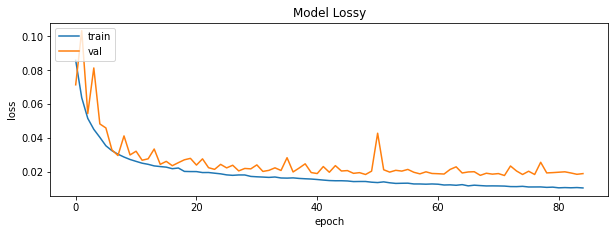

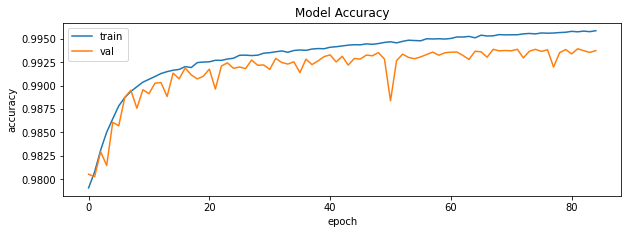

In [15]:
## Dispaly the plot of 
rows = 2
columns = 1
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 1)
plt.plot(metrics['loss'])
plt.plot(metrics['val_loss'])
plt.title('Model Lossy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
  
# Display Train loss vs Validation loss at each Epoch
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(rows, columns, 2)
plt.plot(metrics['accuracy'])
plt.plot(metrics['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
# model.save("model_IoU_"+str(iou_score)+"_.h5")

In [ ]:
# pd.DataFrame(metrics).to_pickle("metrics_IoU_"+str(iou_score)+"_.pkl")

In [ ]:
test_img.shape

In [ ]:
test_img_number = np.random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=Y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.2).astype(np.uint8)

intersection = np.logical_and(Y_test, y_pred_thresholded)
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)

plt.figure(figsize=(16, 8))

intersection = np.logical_and(ground_truth[:,:,0], prediction)
union = np.logical_or(ground_truth[:,:,0], prediction)
iou_score = np.sum(intersection) / np.sum(union)

accuracy = str(round(iou_score * 100, 1))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')

plt.subplot(233)
plt.title('Prediction on test image \n {}%'.format(accuracy))
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
ground_truth.shape

In [ ]:
test_img_norm.shape

In [ ]:
test_img[:,:,0].shape

In [ ]:
test_img[:,:,0][:,:,None].shape

In [ ]:
prediction